In [1]:
%load_ext autoreload
%autoreload 2

# Glow

<center><img src="pics/glow_demo.png" width=600 /></center>

**Article**: [Kingma et. al., 2018](https://arxiv.org/pdf/1807.03039.pdf)

**Credits**: 

The code is based on the following: [github](https://github.com/rosinality/glow-pytorch)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Tdata
import torchvision as TV
import torchvision.transforms as TVtrf
import torchvision.utils as TVutils
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 2
    FULL_DEVICE = 'cuda:{}'.format(GPU_DEVICE)
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

def reset_seed():
    OUTPUT_SEED = 0xBADBEEF
    torch.manual_seed(OUTPUT_SEED)
    np.random.seed(OUTPUT_SEED)

reset_seed()

# DGM utils
import sys
import os
sys.path.append('../../homeworks')
from dgm_utils import train_model, plot_training_curves, show_samples
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data

## Data loading

`CelebA` dataset

In [3]:
transform = TVtrf.Compose([
        TVtrf.CenterCrop(140),
        TVtrf.Resize((64, 64)),
        TVtrf.ToTensor()
        # TVtrf.Normalize((.5, .5, .5), (.5, .5, .5))
    ])

train_celeba = TV.datasets.CelebA(root='./datasets/celeba/', split='train', download=False, transform=transform)
test_celeba = TV.datasets.CelebA(root='./datasets/celeba/', split='test', download=False, transform=transform)

train_loader = Tdata.DataLoader(train_celeba, batch_size=256, shuffle=True)
test_loader = Tdata.DataLoader(test_celeba, batch_size=256, shuffle=False)

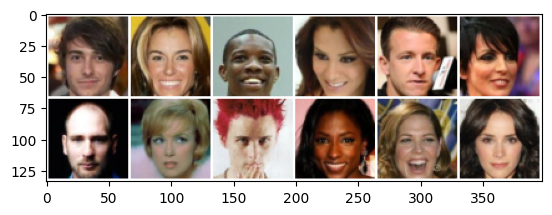

In [4]:
grid = TVtrf.functional.to_pil_image(TVutils.make_grid(next(iter(train_loader))[0][:12], nrow=6, normalize=True, pad_value=1.))
plt.imshow(grid)

### Utilities

In [5]:
def logabs(x):
    return torch.log(torch.abs(x))

# Glow components

<center><img src="pics/glow_activations.png" width=800 /></center>

## ActNorm class

<center><img src="pics/actnorm.png" width=1000 /></center>

In [6]:
class ActNorm(nn.Module):
    def __init__(self, in_channel, logdet=True):
        super().__init__()

        self.loc = nn.Parameter(torch.zeros(1, in_channel, 1, 1))
        self.scale = nn.Parameter(torch.ones(1, in_channel, 1, 1))

        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))
        self.logdet = logdet

    def initialize(self, input):
        with torch.no_grad():
            flatten = input.permute(1, 0, 2, 3).contiguous().view(input.shape[1], -1)
            mean = (
                flatten.mean(1)
                .unsqueeze(1)
                .unsqueeze(2)
                .unsqueeze(3)
                .permute(1, 0, 2, 3)
            )
            std = (
                flatten.std(1)
                .unsqueeze(1)
                .unsqueeze(2)
                .unsqueeze(3)
                .permute(1, 0, 2, 3)
            )

            self.loc.data.copy_(-mean)
            self.scale.data.copy_(1 / (std + 1e-6))

    def forward(self, input):
        _, _, height, width = input.shape

        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)

        log_abs = logabs(self.scale)

        logdet = height * width * torch.sum(log_abs)

        if self.logdet:
            return self.scale * (input + self.loc), logdet

        else:
            return self.scale * (input + self.loc)

    def reverse(self, output):
        return output / self.scale - self.loc

## Invertible `1x1` convolution

<center><img src="pics/inv_1x1_conv.png" width=1000 /></center>

**Reducing `logdet` computation cost by LU decomposition**:

<center><img src="pics/inv_1x1_conv_lu.png" width=1000 /></center>

In [7]:
# implementation without (P)LU decomposition

class InvConv2d(nn.Module):
    def __init__(self, in_channel):
        super().__init__()

        weight = torch.randn(in_channel, in_channel)
        q, _ = torch.qr(weight) # generates random orthogonal matrix
        weight = q.unsqueeze(2).unsqueeze(3)
        self.weight = nn.Parameter(weight)

    def forward(self, input):
        _, _, height, width = input.shape

        out = F.conv2d(input, self.weight)
        logdet = (
            height * width * torch.slogdet(self.weight.squeeze().double())[1].float()
        )

        return out, logdet

    def reverse(self, output):
        return F.conv2d(
            output, self.weight.squeeze().inverse().unsqueeze(2).unsqueeze(3)
        )

# implementation with (P)LU decomposition
from scipy import linalg as la

class InvConv2dLU(nn.Module):
    def __init__(self, in_channel):
        super().__init__()

        weight = np.random.randn(in_channel, in_channel)
        q, _ = la.qr(weight)
        w_p, w_l, w_u = la.lu(q.astype(np.float32))
        w_s = np.diag(w_u)
        w_u = np.triu(w_u, 1)
        u_mask = np.triu(np.ones_like(w_u), 1)
        l_mask = u_mask.T

        w_p = torch.from_numpy(w_p)
        w_l = torch.from_numpy(w_l)
        w_s = torch.from_numpy(w_s)
        w_u = torch.from_numpy(w_u)

        self.register_buffer("w_p", w_p)
        self.register_buffer("u_mask", torch.from_numpy(u_mask))
        self.register_buffer("l_mask", torch.from_numpy(l_mask))
        self.register_buffer("s_sign", torch.sign(w_s))
        self.register_buffer("l_eye", torch.eye(l_mask.shape[0]))
        self.w_l = nn.Parameter(w_l)
        self.w_s = nn.Parameter(logabs(w_s))
        self.w_u = nn.Parameter(w_u)

    def forward(self, input):
        _, _, height, width = input.shape

        weight = self.calc_weight()

        out = F.conv2d(input, weight)
        logdet = height * width * torch.sum(self.w_s)

        return out, logdet

    def calc_weight(self):
        weight = (
            self.w_p
            @ (self.w_l * self.l_mask + self.l_eye)
            @ ((self.w_u * self.u_mask) + torch.diag(self.s_sign * torch.exp(self.w_s)))
        )

        return weight.unsqueeze(2).unsqueeze(3)

    def reverse(self, output):
        weight = self.calc_weight()

        return F.conv2d(output, weight.squeeze().inverse().unsqueeze(2).unsqueeze(3))

## ZeroConv2D

<center><img src="pics/zero_init.png" width=1000 /></center>

In [8]:
class ZeroConv2d(nn.Module):
    def __init__(self, in_channel, out_channel, padding=1):
        super().__init__()

        self.conv = nn.Conv2d(in_channel, out_channel, 3, padding=0)
        self.conv.weight.data.zero_()
        self.conv.bias.data.zero_()
        self.scale = nn.Parameter(torch.zeros(1, out_channel, 1, 1))

    def forward(self, input):
        out = F.pad(input, [1, 1, 1, 1], value=1)
        out = self.conv(out)
        out = out * torch.exp(self.scale * 3)

        return out

## AffineCoupling

Uses `ChannelCoupling` scheme from **RealNVP**:

<center><img src="pics/channelwise_splitting.png" width=500 /></center>

In [9]:
class AffineCoupling(nn.Module):
    def __init__(self, in_channel, filter_size=512, affine=True):
        super().__init__()

        self.affine = affine

        self.net = nn.Sequential(
            nn.Conv2d(in_channel // 2, filter_size, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filter_size, filter_size, 1),
            nn.ReLU(inplace=True),
            ZeroConv2d(filter_size, in_channel if self.affine else in_channel // 2),
        )

        self.net[0].weight.data.normal_(0, 0.05)
        self.net[0].bias.data.zero_()

        self.net[2].weight.data.normal_(0, 0.05)
        self.net[2].bias.data.zero_()

    def forward(self, input):
        in_a, in_b = input.chunk(2, 1)

        if self.affine:
            log_s, t = self.net(in_a).chunk(2, 1)
            # s = torch.exp(log_s)
            s = F.sigmoid(log_s + 2)
            # out_a = s * in_a + t
            out_b = (in_b + t) * s

            logdet = torch.sum(torch.log(s).view(input.shape[0], -1), 1)

        else:
            # particular case of affine couplint: additive coupling
            net_out = self.net(in_a)
            out_b = in_b + net_out
            logdet = None

        return torch.cat([in_a, out_b], 1), logdet

    def reverse(self, output):
        out_a, out_b = output.chunk(2, 1)

        if self.affine:
            log_s, t = self.net(out_a).chunk(2, 1)
            # s = torch.exp(log_s)
            s = F.sigmoid(log_s + 2)
            # in_a = (out_a - t) / s
            in_b = out_b / s - t

        else:
            net_out = self.net(out_a)
            in_b = out_b - net_out

        return torch.cat([out_a, in_b], 1)

## One step of Glow 

<center><img src="pics/glow_one_step.png" width=500 /></center>

In [10]:
class Flow(nn.Module):
    def __init__(self, in_channel, affine=True, conv_lu=True):
        super().__init__()

        self.actnorm = ActNorm(in_channel)

        if conv_lu:
            self.invconv = InvConv2dLU(in_channel)

        else:
            self.invconv = InvConv2d(in_channel)

        self.coupling = AffineCoupling(in_channel, affine=affine)

    def forward(self, input):
        out, logdet = self.actnorm(input)
        out, det1 = self.invconv(out)
        out, det2 = self.coupling(out)

        logdet = logdet + det1
        if det2 is not None:
            logdet = logdet + det2

        return out, logdet

    def reverse(self, output):
        input = self.coupling.reverse(output)
        input = self.invconv.reverse(input)
        input = self.actnorm.reverse(input)

        return input


## Multi-scale architercture of NF 

At each step, half the variables are directly modeled as Gaussians, while the other half undergo further transformation.:

<center><img src="pics/glow_scaling.png" width=500 /></center>

<center><img src="pics/glow_scaling_formulas.png" width=500 /></center>

## Glow one-scale block

Recall the `squeeze`/`unsqueeze` operator from `RealNVP`

<center><img src="pics/squeezing.png" width=800 /></center>

In [11]:
from math import log, pi, exp


def gaussian_log_p(x, mean, log_sd):
    return -0.5 * log(2 * pi) - log_sd - 0.5 * (x - mean) ** 2 / torch.exp(2 * log_sd)


def gaussian_sample(eps, mean, log_sd):
    return mean + torch.exp(log_sd) * eps


class Block(nn.Module):

    def __init__(self, in_channel, n_flow, split=True, affine=True, conv_lu=True):
        super().__init__()

        squeeze_dim = in_channel * 4

        self.flows = nn.ModuleList()
        for i in range(n_flow):
            self.flows.append(Flow(squeeze_dim, affine=affine, conv_lu=conv_lu))

        self.split = split

        if split:
            self.prior = ZeroConv2d(in_channel * 2, in_channel * 4)

        else:
            self.prior = ZeroConv2d(in_channel * 4, in_channel * 8)

    def forward(self, input):
        b_size, n_channel, height, width = input.shape
        # Squeeze operation
        squeezed = input.view(b_size, n_channel, height // 2, 2, width // 2, 2)
        squeezed = squeezed.permute(0, 1, 3, 5, 2, 4)
        out = squeezed.contiguous().view(b_size, n_channel * 4, height // 2, width // 2)

        logdet = 0

        for flow in self.flows:
            out, det = flow(out)
            logdet = logdet + det

        if self.split:
            # out will be transformed further, z_new will be modelled as gaussian
            out, z_new = out.chunk(2, 1) 
            
            # data-dependent prior
            mean, log_sd = self.prior(out).chunk(2, 1)
            log_p = gaussian_log_p(z_new, mean, log_sd)
            log_p = log_p.view(b_size, -1).sum(1)

        else:
            # dummy initialization of data-dependent prior (i.e. it becomes data-independent)
            zero = torch.zeros_like(out)
            mean, log_sd = self.prior(zero).chunk(2, 1)
            log_p = gaussian_log_p(out, mean, log_sd)
            log_p = log_p.view(b_size, -1).sum(1)
            z_new = out

        return out, logdet, log_p, z_new

    def reverse(self, output, eps=None, reconstruct=False):
        '''
        reconstruct: weather output sampled from data-dependent prior or from standard gaussian
        '''
        input = output

        if reconstruct:
            if self.split:
                input = torch.cat([output, eps], 1)

            else:
                input = eps

        else:
            if self.split:
                mean, log_sd = self.prior(input).chunk(2, 1)
                z = gaussian_sample(eps, mean, log_sd)
                input = torch.cat([output, z], 1)

            else:
                zero = torch.zeros_like(input)
                # zero = F.pad(zero, [1, 1, 1, 1], value=1)
                mean, log_sd = self.prior(zero).chunk(2, 1)
                z = gaussian_sample(eps, mean, log_sd)
                input = z

        for flow in self.flows[::-1]:
            input = flow.reverse(input)

        b_size, n_channel, height, width = input.shape
        
        # Unsqueeze operation
        unsqueezed = input.view(b_size, n_channel // 4, 2, 2, height, width)
        unsqueezed = unsqueezed.permute(0, 1, 4, 2, 5, 3)
        unsqueezed = unsqueezed.contiguous().view(
            b_size, n_channel // 4, height * 2, width * 2
        )

        return unsqueezed

# Combining the above togeter: Glow model

<center><img src="pics/glow_scheme.png" width=800 /></center>

In [12]:
class Glow(nn.Module):
    def __init__(
        self, in_channel, n_flow, n_block, affine=True, conv_lu=True
    ):
        super().__init__()

        self.blocks = nn.ModuleList()
        n_channel = in_channel
        for i in range(n_block - 1):
            self.blocks.append(Block(n_channel, n_flow, affine=affine, conv_lu=conv_lu))
            n_channel *= 2 # why does we multiply by 2, not 4?
        self.blocks.append(Block(n_channel, n_flow, split=False, affine=affine))

    def forward(self, input):
        log_p_sum = 0
        logdet = 0
        out = input
        z_outs = []

        for block in self.blocks:
            out, det, log_p, z_new = block(out)
            z_outs.append(z_new)
            logdet = logdet + det

            if log_p is not None:
                log_p_sum = log_p_sum + log_p

        return log_p_sum, logdet, z_outs

    def loss(self, input, image_size=64, n_bins=8):
        log_p, logdet, _ = self.forward(input)
        n_pixel = image_size * image_size * 3
        assert log_p.shape == (input.size(0),)
        assert logdet.shape == (input.size(0),)

        loss = -log(n_bins) * n_pixel
        loss = loss + logdet + log_p

        return {
            "nll_loss": (-loss / (log(2) * n_pixel)).mean(), 
            "logP": (log_p / (log(2) * n_pixel)).mean(),
            "logdet": (logdet / (log(2) * n_pixel)).mean()
            }

    def reverse(self, z_list, reconstruct=False):
        for i, block in enumerate(self.blocks[::-1]):
            if i == 0:
                input = block.reverse(z_list[-1], z_list[-1], reconstruct=reconstruct)

            else:
                input = block.reverse(input, z_list[-(i + 1)], reconstruct=reconstruct)

        return input

### Training

In [13]:
def calc_z_shapes(n_channel, input_size, n_block):
    z_shapes = []

    for i in range(n_block - 1):
        input_size //= 2
        n_channel *= 2 # note mul by 2, not 4

        z_shapes.append((n_channel, input_size, input_size))

    input_size //= 2
    z_shapes.append((n_channel * 4, input_size, input_size))

    return z_shapes

In [16]:
def train(args, model, optimizer, train_loader, loss_key="nll_loss"):

    n_bins = 2.0 ** args.n_bits

    z_sample = []
    z_shapes = calc_z_shapes(3, args.img_size, args.n_block)

    for z in z_shapes:
        z_new = torch.randn(args.n_sample, *z) * args.temp
        z_sample.append(z_new.to(DEVICE))

    forrange = tqdm(range(args.epochs))
    i = 0
    for epoch in forrange:
        for image in train_loader:
            image = image[0].to(DEVICE)

            # image preprocessing
            image = image * 255

            if args.n_bits < 8:
                image = torch.floor(image / 2 ** (8 - args.n_bits))

            image = image / n_bins - 0.5
            
            # note uniform dequantization
            losses = model.loss(image + torch.rand_like(image) / n_bins)

            model.zero_grad()
            losses[loss_key].backward()
            optimizer.step()
            loss, log_p, log_det = losses['nll_loss'].item(), losses['logP'].item(), losses['logdet'].item()

            forrange.set_description(
                f"Loss: {loss:.5f}; logP: {log_p:.5f}; logdet: {log_det:.5f};"
            )

            if i % 100 == 0:
                with torch.no_grad():
                    os.makedirs('./sample', exist_ok=True)
                    TVutils.save_image(
                        model.reverse(z_sample).cpu().data,
                        f"sample/{str(i + 1).zfill(6)}.png",
                        normalize=True,
                        nrow=10,
                        range=(-0.5, 0.5),
                    )
            i += 1



In [17]:
class Config():
    pass

CONFIG = Config()

CONFIG.img_size = 64
CONFIG.batch_size = 256
CONFIG.epochs = 100
CONFIG.n_block = 4 # number of blocks with different resolution
CONFIG.n_flow = 4 # number of flows in each block
CONFIG.no_lu = False
CONFIG.affine = True
CONFIG.n_bits = 5
CONFIG.lr = 1e-4
CONFIG.temp = 0.7 # temperature of sampling (lower temperature reduces the number of outliers)
CONFIG.n_sample = 20

In [ ]:
model = Glow(
        3, CONFIG.n_flow, CONFIG.n_block, affine=CONFIG.affine, conv_lu=not CONFIG.no_lu
    )
# model = model_single
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG.lr)

train(CONFIG, model, optimizer, train_loader)

Loss: -0.27364; logP: -0.55826; logdet: 3.83190;:   0%|                                                                                                              | 0/100 [11:25<?, ?it/s]

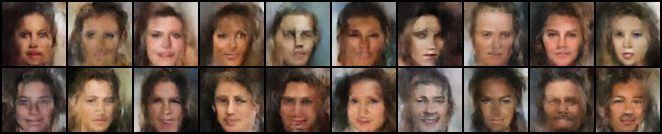

In [4]:
from IPython import display
display.Image("sample/012901.png", width=1000)